In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import numpy as np

from scipy.stats import pearsonr, spearmanr

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from helper_functions import coef_det_k, fixed_scale, ARGUMENTS, label_maker_9000

os.environ["CUDA_VISIBLE_DEVICES"]=""

2023-08-09 11:20:42.713593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
embedings_file = "../results/Embeddings/embedings_all_tms_nonredun_780.pkl"
with open(embedings_file, "rb") as f:
    df = pickle.load(f)

# Reformat data frame as hashmap with keys as id
data_df = {}
for id_, EMB, TM in zip(df["id"], df["Embedding"], df["TM"]):
    data_df[id_] = [EMB, TM]

In [4]:
## Split data into train val test

df_all_30   = pd.read_csv("../data/clu_30_cluster.tsv", sep="\t", header=None, names=["clusters", "sequences"])
#df_all_30.columns = ["clusters", "sequence"]
df_train_30 = pd.read_csv("../data/train_clusters.tsv", sep="\t", header=None, names=["clusters"])
df_val_30   = pd.read_csv("../data/val_clusters.tsv", sep="\t", header=None, names=["clusters"])
df_test_30  = pd.read_csv("../data/test_clusters.tsv", sep="\t", header=None, names=["clusters"])

df_train_30 = df_train_30.merge(df_all_30, on = "clusters", how = "left")
df_val_30   = df_val_30.merge(df_all_30, on = "clusters", how = "left")
df_test_30  = df_test_30.merge(df_all_30, on = "clusters", how = "left")


training_data = df_train_30["sequences"].apply(lambda x: data_df[x])
val_data      = df_val_30["sequences"].apply(lambda x: data_df[x])
test_data     = df_test_30["sequences"].apply(lambda x: data_df[x])

df_train_30["Embedding"], df_train_30["TM"] = zip(*[(eli[0], eli[1]) for eli in training_data])
df_val_30["Embedding"], df_val_30["TM"]     = zip(*[(eli[0], eli[1]) for eli in val_data])
df_test_30["Embedding"], df_test_30["TM"]   = zip(*[(eli[0], eli[1]) for eli in test_data])

df_train_30["class"] = df_train_30.apply(lambda x: label_maker_9000(x["TM"], 60), axis = 1)
df_val_30["class"]   = df_val_30.apply(lambda x: label_maker_9000(x["TM"], 60), axis = 1)
df_test_30["class"]  = df_test_30.apply(lambda x: label_maker_9000(x["TM"], 60), axis = 1)

df_train_30["label"] = df_train_30.apply(lambda x: "Training set", axis = 1)
df_val_30["label"]   = df_val_30.apply(lambda x: "validation set", axis = 1)
df_test_30["label"]  = df_test_30.apply(lambda x: "Testing set", axis = 1)

x_train = np.array(df_train_30["Embedding"].to_list())
y_train = np.array(df_train_30["TM"])
y_train_c = np.array(df_train_30["class"])

x_val   = np.array(df_val_30["Embedding"].to_list())
y_val   = np.array(df_val_30["TM"])
y_val_c = np.array(df_val_30["class"])

x_test = np.array(df_test_30["Embedding"].to_list())
y_test = np.array(df_test_30["TM"])
y_test_c = np.array(df_test_30["class"])

print(f"Training set contains {y_train.size} samples")
print(f"Validation set contains {y_val.size} samples")
print(f"Test set contains {y_test.size} samples")

# One dataframe to rule them all 
df_all = pd.concat([df_train_30, df_val_30, df_test_30])

Training set contains 27568 samples
Validation set contains 3000 samples
Test set contains 3000 samples


/tmp/ipykernel_7439/452974427.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x= y_train, palette="light:g", bins = 30, ax = ax, stat = "probability", kde = True)
/tmp/ipykernel_7439/452974427.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x= y_val, palette="light:g", bins = 30, ax = ax, stat = "probability", kde = True)
/tmp/ipykernel_7439/452974427.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x= y_test, palette="light:g", bins = 30, ax = ax, stat = "probability", kde = True)


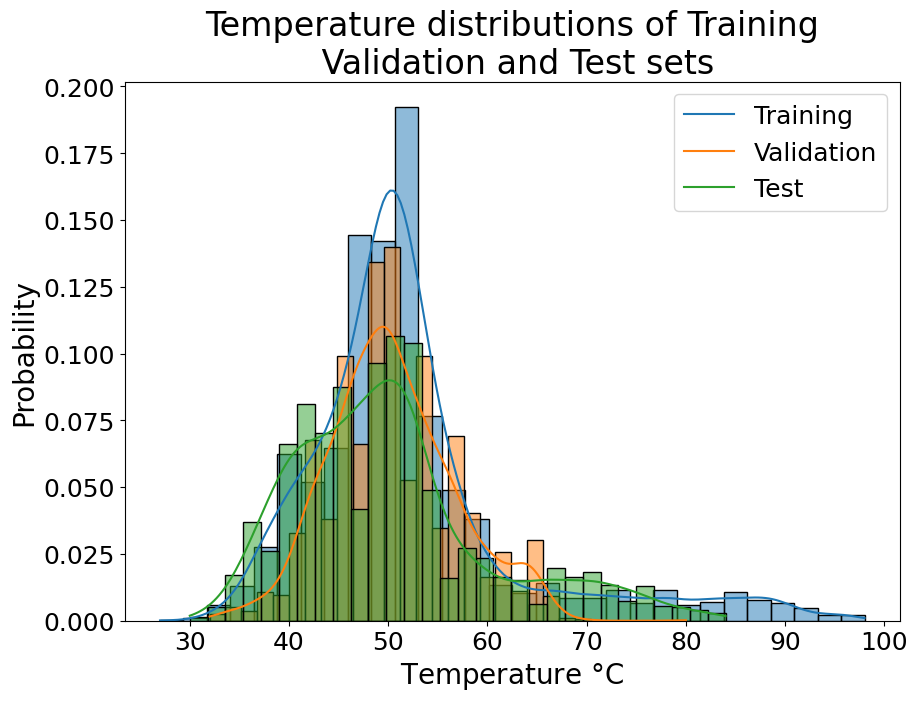

In [5]:
f, ax = plt.subplots(1, figsize=[10,7])
#sns.histplot(data = df_all, x= "TM", hue = "label", bins = 30, ax = ax, stat = "density",multiple="dodge" , kde = True)
sns.histplot(x= y_train, palette="light:g", bins = 30, ax = ax, stat = "probability", kde = True)
sns.histplot(x= y_val, palette="light:g", bins = 30, ax = ax, stat = "probability", kde = True)
sns.histplot(x= y_test, palette="light:g", bins = 30, ax = ax, stat = "probability", kde = True)
plt.title("Temperature distributions of Training\n Validation and Test sets")
plt.legend(["Training", "Validation", "Test"])
ax.set_xlabel(r"Temperature $\degree$C")
plt.savefig("../results/img/temperature_distributions.jpeg")
plt.show()

[0.14183725 0.03853201]
[1525.4662  795.0936]


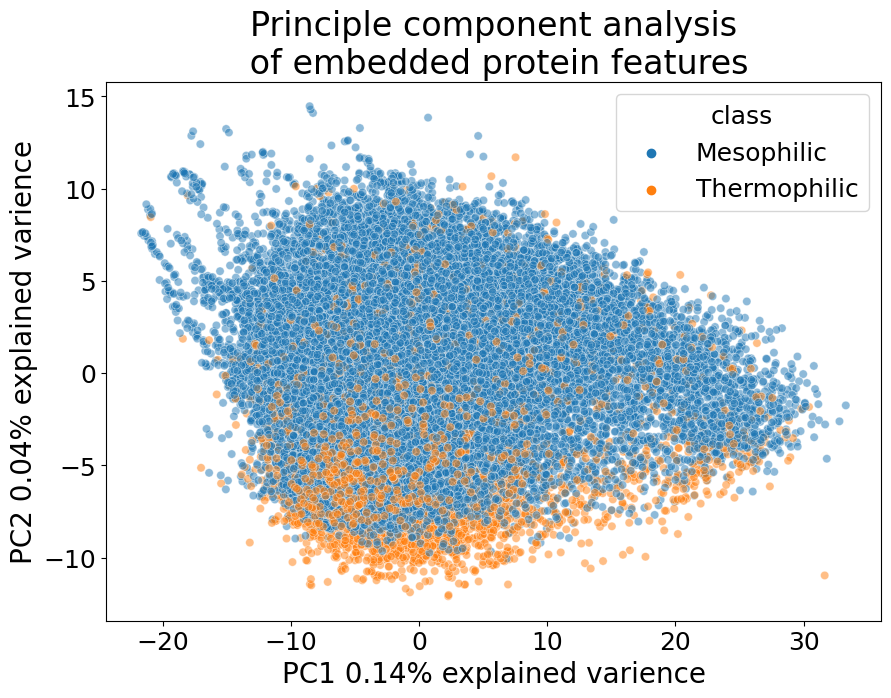

In [6]:
X = np.array(df_all["Embedding"].to_list())
pca = PCA(n_components=2)
pca.fit(X)
PCA(n_components=2)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
df_all["PC1"], df_all["PC2"] = zip(*pca.transform(X))


f, ax = plt.subplots(1, figsize=[10,7])
sns.scatterplot(data = df_all, x = "PC1", y = "PC2", hue = "class", ax = ax, alpha = 0.5)
plt.title("Principle component analysis\n of embedded protein features")
plt.xlabel(f"PC1 {pca.explained_variance_ratio_[0]:.2f}% explained varience")
plt.ylabel(f"PC2 {pca.explained_variance_ratio_[1]:.2f}% explained varience")
#plt.legend([r"TM < 60 $\degree$ C", r"TM >= 60 $\degree$ C"])
plt.savefig("../results/img/embeddings_pca.jpeg")

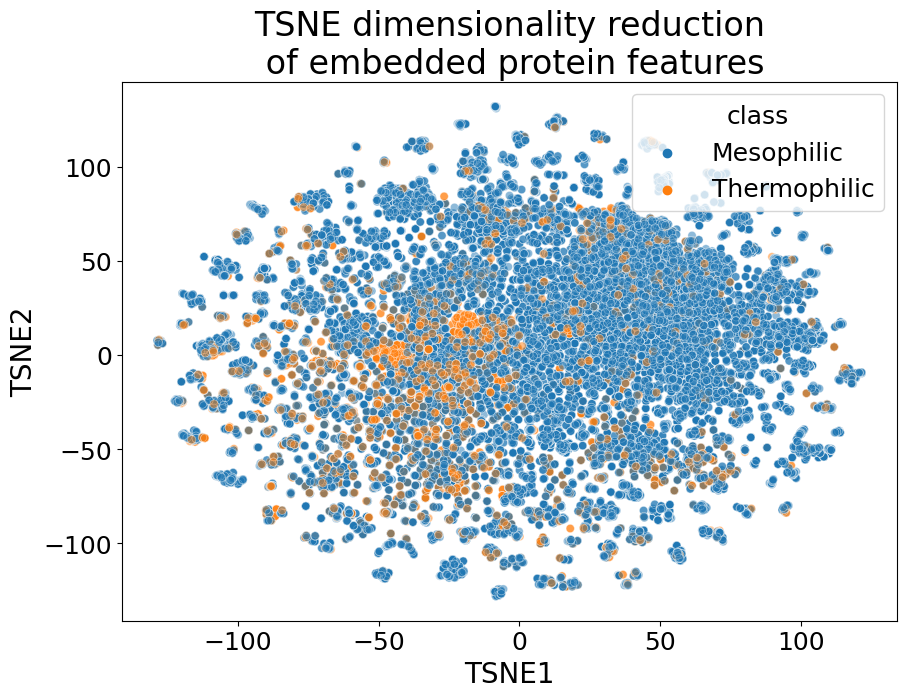

In [7]:
df_all["TSNE1"], df_all["TSNE2"] = zip(*TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(X))
f, ax = plt.subplots(1, figsize=[10,7])
sns.scatterplot(data = df_all, x = "TSNE1", y = "TSNE2", hue = "class", alpha = 0.5)
plt.title("TSNE dimensionality reduction\n of embedded protein features")
plt.savefig("../results/img/embeddings_tsne.jpeg")

In [ ]:
## Base line from classical method

In [8]:


# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(x_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

R square 0.234458080581871  
MSE 77.45745349157094
Median absolute error 5.052174663350417
Explained varience 0.24022034164763095
Pearson correlation 0.5012931415107962
Spearman correlation 0.47014797218969895


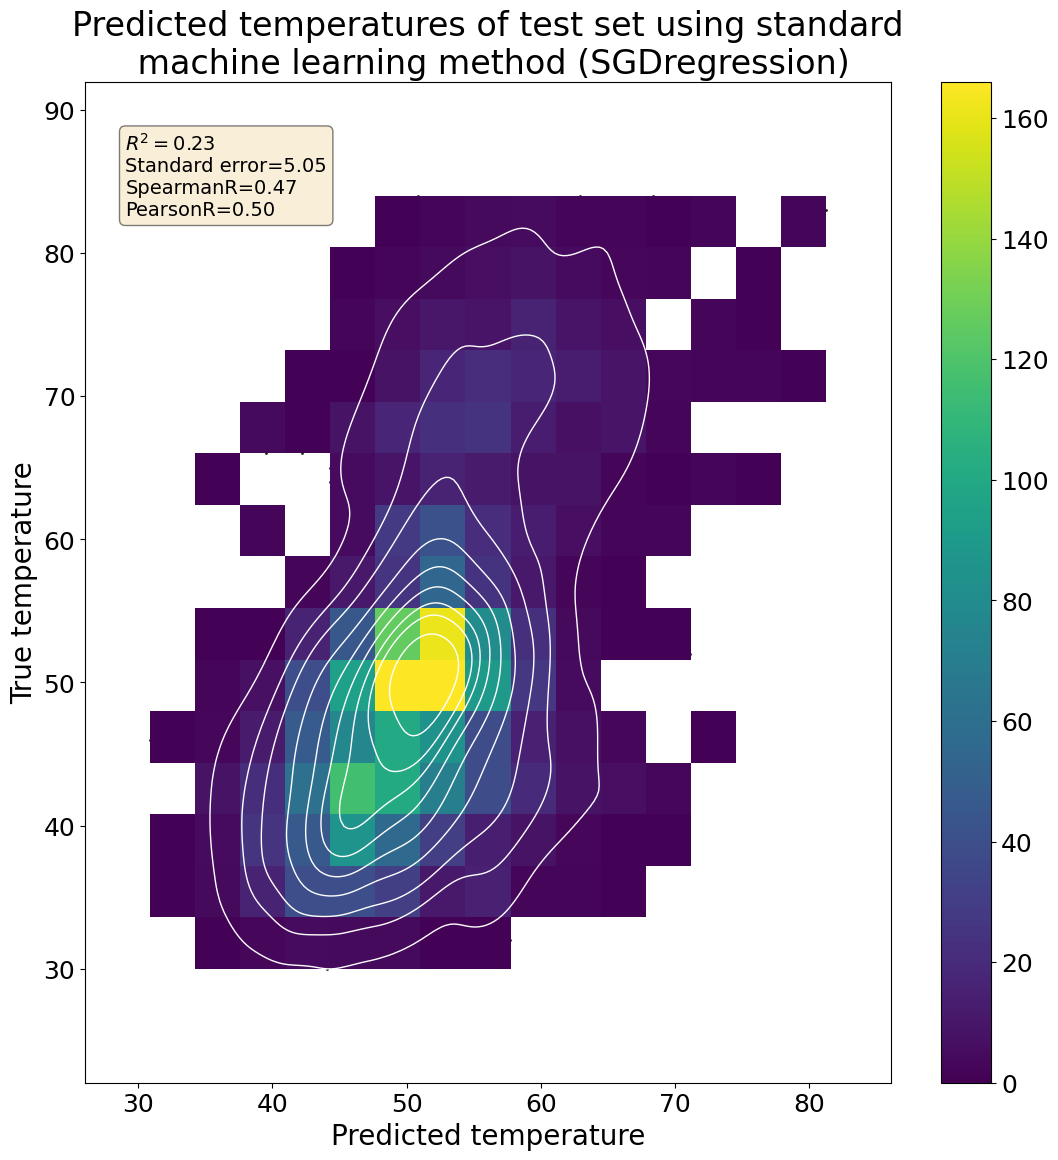

In [9]:




x = reg.predict(x_test)



f, ax = plt.subplots(figsize=[13, 13])
sns.scatterplot(x=x, y=y_test, s=5, color=".15")

sns.histplot(x=x, y=y_test, bins=15,cmap="viridis", cbar = True, pmax = 0.9)
sns.kdeplot(x=x, y=y_test, levels=10, color="w", linewidths=1)
#plt.xlim([2,103])
#plt.ylim([2, 103])
plt.title("Predicted temperatures of test set using standard\n machine learning method (SGDregression)")
plt.xlabel("Predicted temperature")
plt.ylabel("True temperature")

r = sklearn.metrics.r2_score(y_test, x)
e = sklearn.metrics.explained_variance_score(y_test, x)
mse = sklearn.metrics.mean_squared_error(y_test, x)
mdi = sklearn.metrics.median_absolute_error(y_test, x)

corr_p, _ = pearsonr(y_test, x)
corr_s, _ = spearmanr(y_test, x)
print("R square {}  ".format(r))
print("MSE {}".format(mse))
print("Median absolute error {}".format(mdi))
print("Explained varience {}".format(e))
print("Pearson correlation {}".format(corr_p))
print("Spearman correlation {}".format(corr_s))

textstr = '\n'.join((
    r'$R^2=%.2f$' % (r, ),
    r'Standard error=%.2f' % (mdi, ),
    r'SpearmanR=%.2f' % (corr_s, ),
    r'PearsonR=%.2f' % (corr_p, )))


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig("../results/img/classical_baseline.png")



In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512,input_shape=(1280,), activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation = "linear"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 512)              

In [10]:
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#              loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError(), metrics=[coef_det_k])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.00001)
estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,start_from_epoch=20, restore_best_weights=True)
model_no_scale = "../results/Models/No_Scale/"
chkp = tf.keras.callbacks.ModelCheckpoint(
    model_no_scale,
    monitor = 'val_loss',
    save_best_only = True)

In [11]:
history = model.fit(x = x_train, y = y_train, batch_size = 64, validation_data = (x_val, y_val), epochs=100, callbacks=[reduce_lr, estop, chkp]) 

Epoch 1/100
427/431 [============================>.] - ETA: 0s - loss: 1441.1619 - coef_det_k: -12.3474

INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


431/431 [==============================] - 9s 18ms/step - loss: 1429.7507 - coef_det_k: -12.2309 - val_loss: 100.4892 - val_coef_det_k: -1.9999 - lr: 0.0010
Epoch 2/100
428/431 [============================>.] - ETA: 0s - loss: 90.2009 - coef_det_k: 0.1892

INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


431/431 [==============================] - 7s 16ms/step - loss: 90.1816 - coef_det_k: 0.1896 - val_loss: 71.0065 - val_coef_det_k: -1.0774 - lr: 0.0010
Epoch 3/100
430/431 [============================>.] - ETA: 0s - loss: 76.6079 - coef_det_k: 0.3163

INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


431/431 [==============================] - 7s 16ms/step - loss: 76.5634 - coef_det_k: 0.3170 - val_loss: 59.8190 - val_coef_det_k: -0.7424 - lr: 0.0010
Epoch 4/100
429/431 [============================>.] - ETA: 0s - loss: 71.0790 - coef_det_k: 0.3518

INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


431/431 [==============================] - 7s 16ms/step - loss: 71.0698 - coef_det_k: 0.3525 - val_loss: 58.2548 - val_coef_det_k: -0.6861 - lr: 0.0010
Epoch 5/100
431/431 [==============================] - 5s 13ms/step - loss: 64.9582 - coef_det_k: 0.4139 - val_loss: 63.3375 - val_coef_det_k: -0.8362 - lr: 0.0010
Epoch 6/100
429/431 [============================>.] - ETA: 0s - loss: 60.4729 - coef_det_k: 0.4508

INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


431/431 [==============================] - 8s 18ms/step - loss: 60.4676 - coef_det_k: 0.4510 - val_loss: 56.8556 - val_coef_det_k: -0.6693 - lr: 0.0010
Epoch 7/100
431/431 [==============================] - 5s 13ms/step - loss: 57.4007 - coef_det_k: 0.4789 - val_loss: 61.1798 - val_coef_det_k: -0.8010 - lr: 0.0010
Epoch 8/100
431/431 [==============================] - 6s 13ms/step - loss: 53.9201 - coef_det_k: 0.5175 - val_loss: 57.6918 - val_coef_det_k: -0.6806 - lr: 0.0010
Epoch 9/100
427/431 [============================>.] - ETA: 0s - loss: 51.7741 - coef_det_k: 0.5330

INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


431/431 [==============================] - 7s 16ms/step - loss: 51.7129 - coef_det_k: 0.5328 - val_loss: 52.9733 - val_coef_det_k: -0.5376 - lr: 0.0010
Epoch 10/100
431/431 [==============================] - 6s 13ms/step - loss: 50.3694 - coef_det_k: 0.5473 - val_loss: 62.9652 - val_coef_det_k: -0.8241 - lr: 0.0010
Epoch 11/100
431/431 [==============================] - 6s 13ms/step - loss: 48.8847 - coef_det_k: 0.5560 - val_loss: 58.6898 - val_coef_det_k: -0.7257 - lr: 0.0010
Epoch 12/100
431/431 [==============================] - 6s 13ms/step - loss: 48.3168 - coef_det_k: 0.5602 - val_loss: 54.1448 - val_coef_det_k: -0.5890 - lr: 0.0010
Epoch 13/100
431/431 [==============================] - 6s 13ms/step - loss: 46.1904 - coef_det_k: 0.5831 - val_loss: 58.0310 - val_coef_det_k: -0.6857 - lr: 0.0010
Epoch 14/100
431/431 [==============================] - 6s 13ms/step - loss: 45.5294 - coef_det_k: 0.5827 - val_loss: 55.6649 - val_coef_det_k: -0.6305 - lr: 0.0010
Epoch 15/100
431/431 [=

INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


431/431 [==============================] - 7s 16ms/step - loss: 42.5882 - coef_det_k: 0.6156 - val_loss: 49.3415 - val_coef_det_k: -0.4378 - lr: 0.0010
Epoch 19/100
431/431 [==============================] - 6s 13ms/step - loss: 41.5356 - coef_det_k: 0.6208 - val_loss: 60.3685 - val_coef_det_k: -0.7591 - lr: 0.0010
Epoch 20/100
431/431 [==============================] - 5s 13ms/step - loss: 41.0174 - coef_det_k: 0.6292 - val_loss: 56.7630 - val_coef_det_k: -0.6564 - lr: 0.0010
Epoch 21/100
431/431 [==============================] - 6s 13ms/step - loss: 40.4029 - coef_det_k: 0.6349 - val_loss: 54.5273 - val_coef_det_k: -0.5853 - lr: 0.0010
Epoch 22/100
431/431 [==============================] - 6s 13ms/step - loss: 40.0214 - coef_det_k: 0.6386 - val_loss: 57.3588 - val_coef_det_k: -0.6620 - lr: 0.0010
Epoch 23/100
431/431 [==============================] - 6s 13ms/step - loss: 39.6610 - coef_det_k: 0.6354 - val_loss: 53.2089 - val_coef_det_k: -0.5486 - lr: 0.0010
Epoch 24/100
431/431 [=

INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/No_Scale/assets


431/431 [==============================] - 7s 16ms/step - loss: 38.1451 - coef_det_k: 0.6536 - val_loss: 48.1064 - val_coef_det_k: -0.3841 - lr: 0.0010
Epoch 28/100
431/431 [==============================] - 6s 13ms/step - loss: 37.8259 - coef_det_k: 0.6598 - val_loss: 59.7938 - val_coef_det_k: -0.7301 - lr: 0.0010
Epoch 29/100
431/431 [==============================] - 6s 13ms/step - loss: 37.8139 - coef_det_k: 0.6607 - val_loss: 61.1385 - val_coef_det_k: -0.7744 - lr: 0.0010
Epoch 30/100
431/431 [==============================] - 6s 13ms/step - loss: 37.7636 - coef_det_k: 0.6561 - val_loss: 62.3320 - val_coef_det_k: -0.7858 - lr: 0.0010
Epoch 31/100
431/431 [==============================] - 6s 13ms/step - loss: 36.9988 - coef_det_k: 0.6663 - val_loss: 55.9469 - val_coef_det_k: -0.6193 - lr: 0.0010
Epoch 32/100
431/431 [==============================] - 6s 13ms/step - loss: 36.9348 - coef_det_k: 0.6569 - val_loss: 58.9517 - val_coef_det_k: -0.7025 - lr: 0.0010
Epoch 33/100
431/431 [=

94/94 [==============================] - 0s 3ms/step
R square 0.40145850985020337  
MSE 60.56036705513365
Median absolute error 3.8251476287841797
Explained varience 0.40500013826391823
Pearson correlation 0.6396515261839667
Spearman correlation 0.6527357942295803
Reacal at 60 = 0.4060324825986079
Precision at 60 = 0.8413461538461539
F1 at 60 = 0.5477308294209703


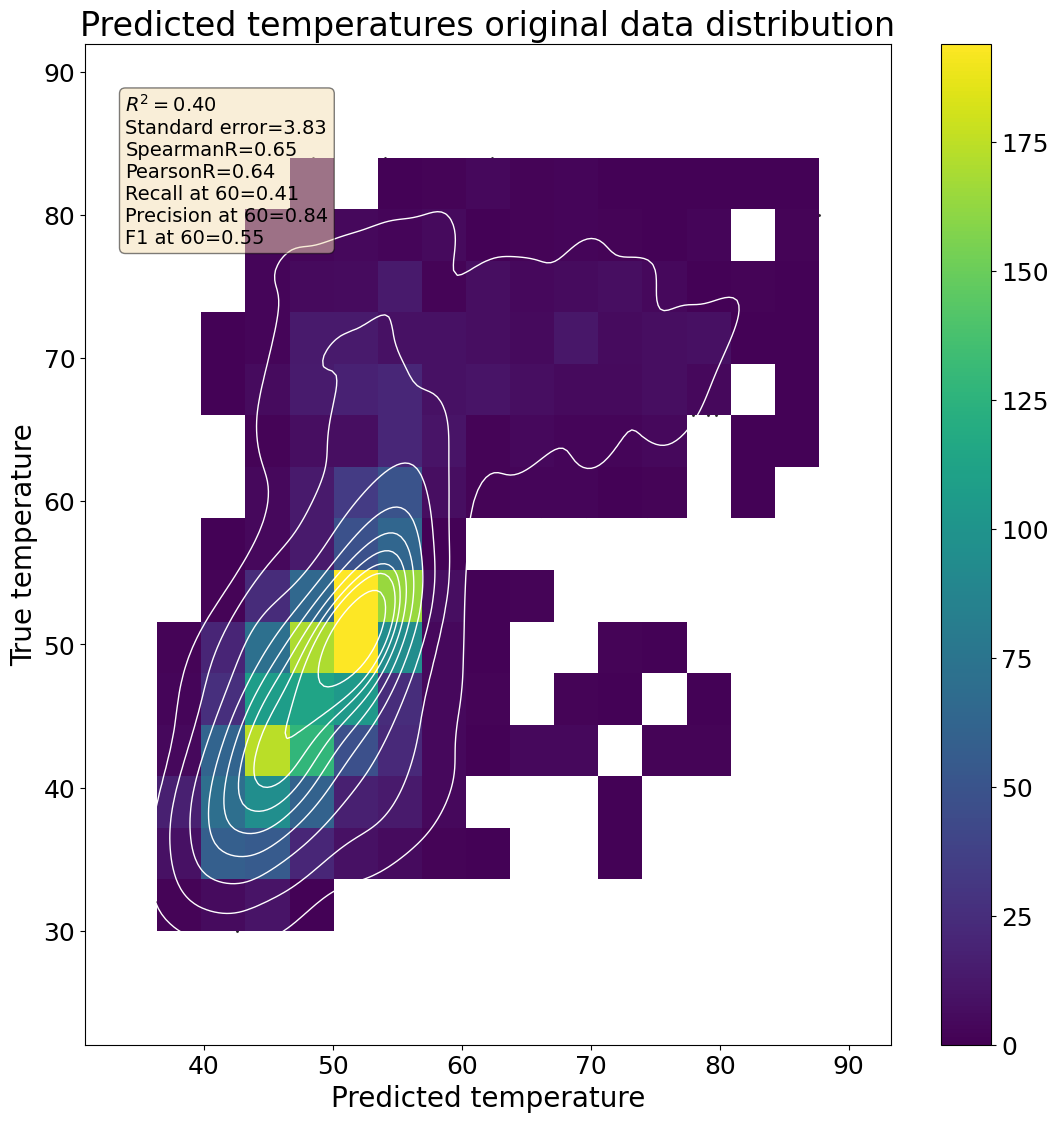

In [122]:
top_temp = 60

model_no_scale = "../results/Models/No_Scale/"
model = tf.keras.models.load_model(
    model_no_scale, custom_objects={"coef_det_k":coef_det_k}, compile=True, options=None)
x = model.predict(x_test)

x = x.reshape((x.shape[0]))

f, ax = plt.subplots(figsize=[13, 13])
sns.scatterplot(x=x, y=y_test, s=5, color=".15")

sns.histplot(x=x, y=y_test, bins=15,cmap="viridis", cbar = True, pmax = 0.9)
sns.kdeplot(x=x, y=y_test, levels=10, color="w", linewidths=1)
#plt.xlim([2,103])
#plt.ylim([2, 103])
plt.title("Predicted temperatures original data distribution")
plt.xlabel("Predicted temperature")
plt.ylabel("True temperature")

r = sklearn.metrics.r2_score(y_test, x)
e = sklearn.metrics.explained_variance_score(y_test, x)
mse = sklearn.metrics.mean_squared_error(y_test, x)
mdi = sklearn.metrics.median_absolute_error(y_test, x)

precision_60 = sklearn.metrics.precision_score(y_test > top_temp, x > top_temp)
f1_60 = sklearn.metrics.f1_score(y_test > top_temp, x > top_temp)
recal_60 = sklearn.metrics.recall_score(y_test > top_temp, x > top_temp) #y_test[y_test > top_temp] > top_temp, x[y_test > top_temp] > top_temp)
mdi_60 = sklearn.metrics.median_absolute_error(y_test[y_test > top_temp], x[y_test > top_temp])

corr_p, _ = pearsonr(y_test, x)
corr_s, _ = spearmanr(y_test, x)
print("R square {}  ".format(r))
print("MSE {}".format(mse))
print("Median absolute error {}".format(mdi))
print("Explained varience {}".format(e))
print("Pearson correlation {}".format(corr_p))
print("Spearman correlation {}".format(corr_s))
print(f"Reacal at {top_temp} = {recal_60}")
print(f"Precision at {top_temp} = {precision_60}")
print(f"F1 at {top_temp} = {f1_60}")

textstr = '\n'.join((
    r'$R^2=%.2f$' % (r, ),
    r'Standard error=%.2f' % (mdi, ),
    r'SpearmanR=%.2f' % (corr_s, ),
    r'PearsonR=%.2f' % (corr_p, ),
    r'Recall at %d=%.2f' % (top_temp, recal_60,),
    r'Precision at %d=%.2f' % (top_temp, precision_60),
    r'F1 at %d=%.2f' % (top_temp, f1_60)))


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig("../results/img/img_NN.png")



TM
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]
no sequences at temperature range [28, 29]


/tmp/ipykernel_7439/172253866.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_scaled, bins = 71, x= "TM", palette="light:g")


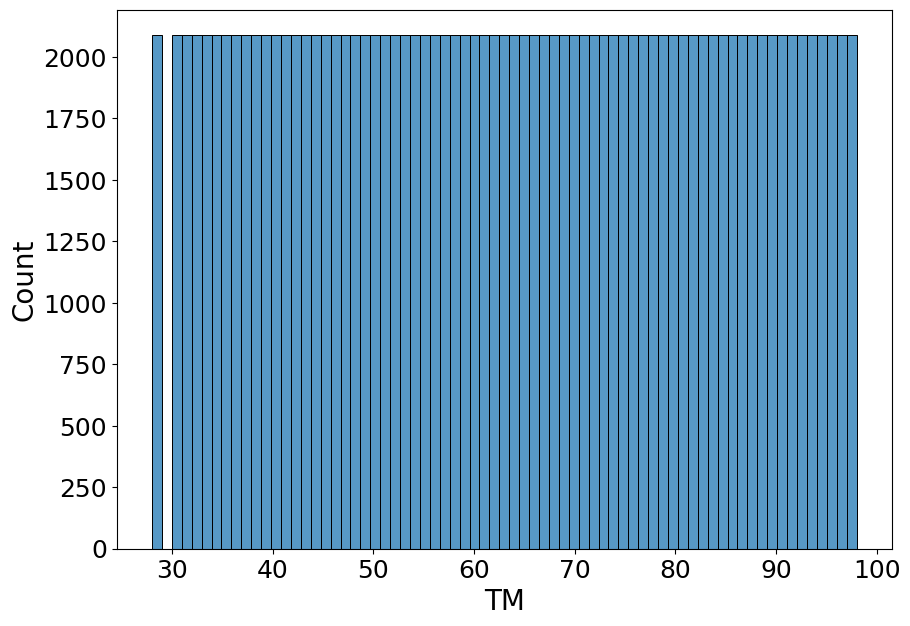

In [14]:

df_train_30.groupby("TM")

max_counts = int(df_train_30.groupby("TM").size().reset_index(name ="counts").max()["counts"])

args = ARGUMENTS(ranges = [0] , enumerate = 1, fixed_scale = max_counts, name = "TM")
df_scaled = fixed_scale(args, df_train_30, use_min=False)

plt.figure(figsize=[10,7])
sns.histplot(data=df_scaled, bins = 71, x= "TM", palette="light:g")
plt.show()


In [16]:
x_train = np.array(df_scaled["Embedding"].to_list())
y_train = np.array(df_scaled["TM"])

model_up = tf.keras.Sequential()
model_up.add(tf.keras.layers.Dense(512,input_shape=(1280,), activation="relu"))
model_up.add(tf.keras.layers.BatchNormalization())
model_up.add(tf.keras.layers.Dropout(0.5))
model_up.add(tf.keras.layers.Dense(512, activation="relu"))
model_up.add(tf.keras.layers.BatchNormalization())
model_up.add(tf.keras.layers.Dropout(0.5))
model_up.add(tf.keras.layers.Dense(256, activation="relu"))
model_up.add(tf.keras.layers.BatchNormalization())
model_up.add(tf.keras.layers.Dropout(0.4))
model_up.add(tf.keras.layers.Dense(1, activation = "linear"))
model_up.summary()

model_up.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError(), metrics=[coef_det_k])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.00001)
estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,start_from_epoch=10, restore_best_weights=True)
model_up_scale = "../results/Models/up_Scale/"
chkp = tf.keras.callbacks.ModelCheckpoint(
    model_up_scale,
    monitor = 'val_loss',
    save_best_only = True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               655872    
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 512)              

In [17]:
history_up = model_up.fit(x = x_train, y = y_train, batch_size = 64, validation_data = (x_val, y_val), epochs=100, callbacks=[reduce_lr, estop, chkp]) 

Epoch 1/100
2279/2283 [============================>.] - ETA: 0s - loss: 517.9452 - coef_det_k: -0.3014

INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


2283/2283 [==============================] - 32s 13ms/step - loss: 517.2509 - coef_det_k: -0.2995 - val_loss: 95.5851 - val_coef_det_k: -1.8828 - lr: 0.0010
Epoch 2/100
2283/2283 [==============================] - 28s 12ms/step - loss: 72.3593 - coef_det_k: 0.8172 - val_loss: 104.6241 - val_coef_det_k: -2.1474 - lr: 0.0010
Epoch 3/100
2283/2283 [==============================] - 29s 13ms/step - loss: 60.1503 - coef_det_k: 0.8478 - val_loss: 98.6097 - val_coef_det_k: -1.8742 - lr: 0.0010
Epoch 4/100
2280/2283 [============================>.] - ETA: 0s - loss: 54.1128 - coef_det_k: 0.8633

INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


2283/2283 [==============================] - 30s 13ms/step - loss: 54.1127 - coef_det_k: 0.8633 - val_loss: 88.3683 - val_coef_det_k: -1.6183 - lr: 0.0010
Epoch 5/100
2283/2283 [==============================] - 29s 13ms/step - loss: 50.3195 - coef_det_k: 0.8729 - val_loss: 93.7801 - val_coef_det_k: -1.7577 - lr: 0.0010
Epoch 6/100
2283/2283 [==============================] - ETA: 0s - loss: 47.9397 - coef_det_k: 0.8788

INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


2283/2283 [==============================] - 31s 14ms/step - loss: 47.9397 - coef_det_k: 0.8788 - val_loss: 87.4096 - val_coef_det_k: -1.5990 - lr: 0.0010
Epoch 7/100
2283/2283 [==============================] - 29s 13ms/step - loss: 46.3317 - coef_det_k: 0.8828 - val_loss: 95.3532 - val_coef_det_k: -1.8152 - lr: 0.0010
Epoch 8/100
2283/2283 [==============================] - 29s 13ms/step - loss: 44.5122 - coef_det_k: 0.8875 - val_loss: 100.7528 - val_coef_det_k: -1.9872 - lr: 0.0010
Epoch 9/100
2283/2283 [==============================] - 29s 13ms/step - loss: 42.7934 - coef_det_k: 0.8919 - val_loss: 87.6399 - val_coef_det_k: -1.5815 - lr: 0.0010
Epoch 10/100
2283/2283 [==============================] - 29s 13ms/step - loss: 42.5817 - coef_det_k: 0.8924 - val_loss: 107.6061 - val_coef_det_k: -2.1982 - lr: 0.0010
Epoch 11/100
2283/2283 [==============================] - 29s 13ms/step - loss: 41.3086 - coef_det_k: 0.8954 - val_loss: 98.6500 - val_coef_det_k: -1.9302 - lr: 0.0010
Epoch 

INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


2283/2283 [==============================] - 30s 13ms/step - loss: 39.2051 - coef_det_k: 0.9008 - val_loss: 81.8850 - val_coef_det_k: -1.4233 - lr: 0.0010
Epoch 15/100
2283/2283 [==============================] - ETA: 0s - loss: 38.5674 - coef_det_k: 0.9025

INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


2283/2283 [==============================] - 30s 13ms/step - loss: 38.5674 - coef_det_k: 0.9025 - val_loss: 80.6365 - val_coef_det_k: -1.3894 - lr: 0.0010
Epoch 16/100
2283/2283 [==============================] - 29s 13ms/step - loss: 38.3101 - coef_det_k: 0.9031 - val_loss: 84.9604 - val_coef_det_k: -1.4928 - lr: 0.0010
Epoch 17/100
2283/2283 [==============================] - 29s 13ms/step - loss: 37.1690 - coef_det_k: 0.9061 - val_loss: 91.7972 - val_coef_det_k: -1.7434 - lr: 0.0010
Epoch 18/100
2283/2283 [==============================] - 29s 13ms/step - loss: 37.3032 - coef_det_k: 0.9056 - val_loss: 86.8070 - val_coef_det_k: -1.5844 - lr: 0.0010
Epoch 19/100
2283/2283 [==============================] - 29s 13ms/step - loss: 36.7287 - coef_det_k: 0.9073 - val_loss: 83.3567 - val_coef_det_k: -1.4502 - lr: 0.0010
Epoch 20/100
2283/2283 [==============================] - 29s 13ms/step - loss: 36.3330 - coef_det_k: 0.9081 - val_loss: 89.5529 - val_coef_det_k: -1.6192 - lr: 0.0010
Epoch

INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


2283/2283 [==============================] - 30s 13ms/step - loss: 35.6052 - coef_det_k: 0.9099 - val_loss: 79.9100 - val_coef_det_k: -1.3403 - lr: 0.0010
Epoch 22/100
2283/2283 [==============================] - 29s 13ms/step - loss: 35.3252 - coef_det_k: 0.9108 - val_loss: 91.9283 - val_coef_det_k: -1.7360 - lr: 0.0010
Epoch 23/100
2283/2283 [==============================] - 29s 13ms/step - loss: 35.0318 - coef_det_k: 0.9115 - val_loss: 86.3124 - val_coef_det_k: -1.5403 - lr: 0.0010
Epoch 24/100
2283/2283 [==============================] - 29s 13ms/step - loss: 35.1566 - coef_det_k: 0.9110 - val_loss: 82.0968 - val_coef_det_k: -1.4069 - lr: 0.0010
Epoch 25/100
2283/2283 [==============================] - 29s 13ms/step - loss: 34.4552 - coef_det_k: 0.9128 - val_loss: 84.3557 - val_coef_det_k: -1.4845 - lr: 0.0010
Epoch 26/100
2283/2283 [==============================] - 29s 13ms/step - loss: 34.0605 - coef_det_k: 0.9137 - val_loss: 90.0032 - val_coef_det_k: -1.6426 - lr: 0.0010
Epoch

INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/up_Scale/assets


2283/2283 [==============================] - 31s 14ms/step - loss: 33.2571 - coef_det_k: 0.9160 - val_loss: 77.8844 - val_coef_det_k: -1.2976 - lr: 0.0010
Epoch 31/100
2283/2283 [==============================] - 29s 13ms/step - loss: 33.3290 - coef_det_k: 0.9157 - val_loss: 83.4414 - val_coef_det_k: -1.4485 - lr: 0.0010
Epoch 32/100
2283/2283 [==============================] - 29s 13ms/step - loss: 32.6035 - coef_det_k: 0.9175 - val_loss: 82.3690 - val_coef_det_k: -1.4306 - lr: 0.0010
Epoch 33/100
2283/2283 [==============================] - 29s 13ms/step - loss: 32.7173 - coef_det_k: 0.9172 - val_loss: 85.7265 - val_coef_det_k: -1.5209 - lr: 0.0010
Epoch 34/100
2283/2283 [==============================] - 28s 12ms/step - loss: 32.5942 - coef_det_k: 0.9176 - val_loss: 87.8367 - val_coef_det_k: -1.5798 - lr: 0.0010
Epoch 35/100
2283/2283 [==============================] - 29s 13ms/step - loss: 32.3394 - coef_det_k: 0.9182 - val_loss: 82.8035 - val_coef_det_k: -1.4427 - lr: 0.0010
Epoch

94/94 [==============================] - 0s 3ms/step
R square 0.3415321478457959  
MSE 66.62371026356765
Median absolute error 3.888212203979492
Explained varience 0.3437300765028234
Pearson correlation 0.6514999063273038
Spearman correlation 0.6429399950886036
Reacal at 60 = 0.5591647331786543
Precision at 60 = 0.6945244956772334
F1 at 60 = 0.6195372750642675


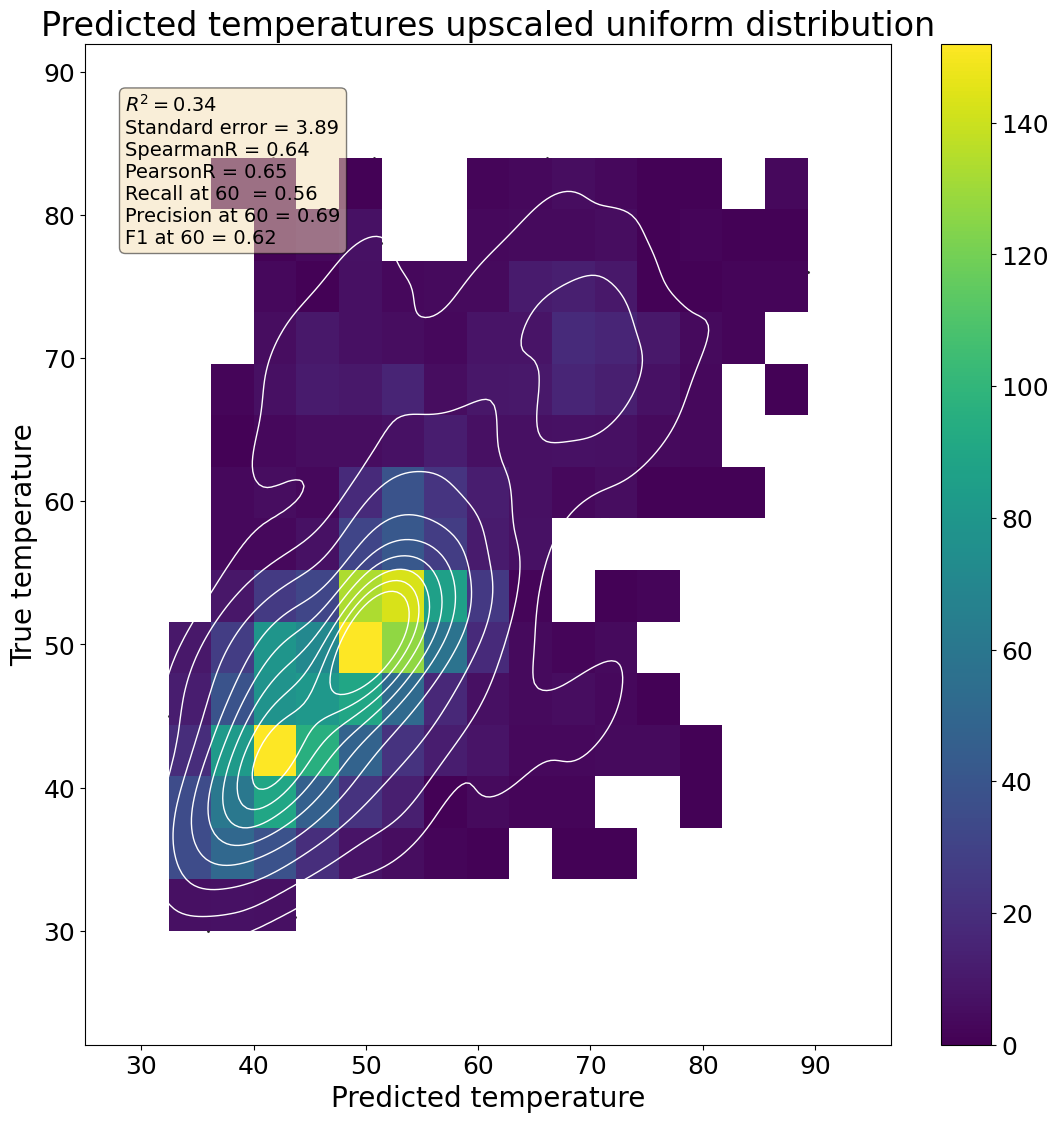

In [121]:
top_temp = 60
x = model_up.predict(x_test)

x = x.reshape((x.shape[0]))

f, ax = plt.subplots(figsize=[13, 13])
sns.scatterplot(x=x, y=y_test, s=5, color=".15")

sns.histplot(x=x, y=y_test, bins=15,cmap="viridis", cbar = True, pmax = 0.9)
sns.kdeplot(x=x, y=y_test, levels=10, color="w", linewidths=1)
#plt.xlim([2,103])
#plt.ylim([2, 103])
plt.title("Predicted temperatures upscaled uniform distribution")
plt.xlabel("Predicted temperature")
plt.ylabel("True temperature")

r = sklearn.metrics.r2_score(y_test, x)
e = sklearn.metrics.explained_variance_score(y_test, x)
mse = sklearn.metrics.mean_squared_error(y_test, x)
mdi = sklearn.metrics.median_absolute_error(y_test, x)

precision_60_up = sklearn.metrics.precision_score(y_test > top_temp, x > top_temp)
f1_60_up = sklearn.metrics.f1_score(y_test > top_temp, x > top_temp)
recal_60_up = sklearn.metrics.recall_score(y_test > top_temp, x > top_temp)
mdi_60_up = sklearn.metrics.median_absolute_error(y_test[y_test > top_temp], x[y_test > top_temp])

corr_p, _ = pearsonr(y_test, x)
corr_s, _ = spearmanr(y_test, x)
print("R square {}  ".format(r))
print("MSE {}".format(mse))
print("Median absolute error {}".format(mdi))
print("Explained varience {}".format(e))
print("Pearson correlation {}".format(corr_p))
print("Spearman correlation {}".format(corr_s))
print(f"Reacal at {top_temp} = {recal_60_up}")
print(f"Precision at {top_temp} = {precision_60_up}")
print(f"F1 at {top_temp} = {f1_60_up}")

textstr = '\n'.join((
    r'$R^2 = %.2f$' % (r, ),
    r'Standard error = %.2f' % (mdi, ),
    r'SpearmanR = %.2f' % (corr_s, ),
    r'PearsonR = %.2f' % (corr_p, ),
    r'Recall at %d  = %.2f' % (top_temp, recal_60_up,),
    r'Precision at %d = %.2f' % (top_temp, precision_60_up),
    r'F1 at %d = %.2f' % (top_temp, f1_60_up)))


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig("../results/img/img_reg_upscale.png")



In [ ]:

sklearn.metrics.recall_score()

TM
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]
no sequences at temperature range [28, 29]


/tmp/ipykernel_7439/4073161896.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_scaled, bins = 71, x= "TM", palette="light:g")


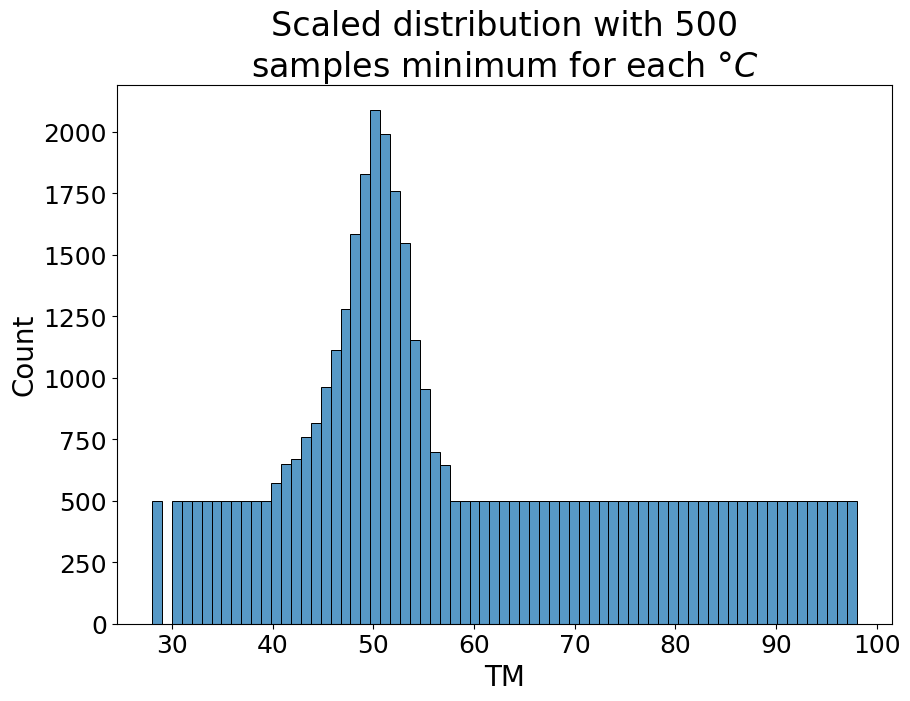

In [77]:
df_train_30.groupby("TM")



args = ARGUMENTS(ranges = [0] , enumerate = 1, fixed_scale = 500, name = "TM")
df_scaled = fixed_scale(args, df_train_30, use_min=True)

plt.figure(figsize=[10,7])
sns.histplot(data=df_scaled, bins = 71, x= "TM", palette="light:g")
plt.title("Scaled distribution with 500" "\n" r"samples minimum for each $\degree C$")
plt.show()


In [131]:
x_train = np.array(df_scaled["Embedding"].to_list())
y_train = np.array(df_scaled["TM"])

model_up_200 = tf.keras.Sequential()
model_up_200.add(tf.keras.layers.Dense(512,input_shape=(1280,), activation="relu"))
model_up_200.add(tf.keras.layers.BatchNormalization())
model_up_200.add(tf.keras.layers.Dropout(0.5))
model_up_200.add(tf.keras.layers.Dense(512, activation="relu"))
model_up_200.add(tf.keras.layers.BatchNormalization())
model_up_200.add(tf.keras.layers.Dropout(0.5))
model_up_200.add(tf.keras.layers.Dense(256, activation="relu"))
model_up_200.add(tf.keras.layers.BatchNormalization())
model_up_200.add(tf.keras.layers.Dropout(0.4))
model_up_200.add(tf.keras.layers.Dense(1, activation = "linear"))
model_up_200.summary()

model_up_200.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(), metrics=[coef_det_k])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.0001)
estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=21,start_from_epoch=10, restore_best_weights=True)
model_up_200_scale = "../results/Models/up_200_Scale/"
chkp = tf.keras.callbacks.ModelCheckpoint(
    model_up_200_scale,
    monitor = 'val_loss',
    save_best_only = True)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 512)               655872    
                                                                 
 batch_normalization_26 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_27 (Dropout)        (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_27 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_28 (Dropout)        (None, 512)              

In [132]:
history_up_200 = model_up_200.fit(x = x_train, y = y_train, batch_size = 32, validation_data = (x_val, y_val), epochs=100, callbacks=[reduce_lr, estop, chkp]) 

Epoch 1/100
1467/1472 [============================>.] - ETA: 0s - loss: 174.7324 - coef_det_k: 0.4605

INFO:tensorflow:Assets written to: ../results/Models/up_200_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/up_200_Scale/assets


1472/1472 [==============================] - 19s 12ms/step - loss: 174.4920 - coef_det_k: 0.4612 - val_loss: 114.5211 - val_coef_det_k: -2.9456 - lr: 0.0100
Epoch 2/100
1469/1472 [============================>.] - ETA: 0s - loss: 78.5848 - coef_det_k: 0.7536

INFO:tensorflow:Assets written to: ../results/Models/up_200_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/up_200_Scale/assets


1472/1472 [==============================] - 17s 12ms/step - loss: 78.5642 - coef_det_k: 0.7533 - val_loss: 98.5282 - val_coef_det_k: -2.2042 - lr: 0.0100
Epoch 3/100
1471/1472 [============================>.] - ETA: 0s - loss: 75.3932 - coef_det_k: 0.7600

INFO:tensorflow:Assets written to: ../results/Models/up_200_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/up_200_Scale/assets


1472/1472 [==============================] - 17s 12ms/step - loss: 75.4353 - coef_det_k: 0.7594 - val_loss: 81.4681 - val_coef_det_k: -1.6888 - lr: 0.0100
Epoch 4/100
1468/1472 [============================>.] - ETA: 0s - loss: 71.7857 - coef_det_k: 0.7733

INFO:tensorflow:Assets written to: ../results/Models/up_200_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/up_200_Scale/assets


1472/1472 [==============================] - 19s 13ms/step - loss: 71.7809 - coef_det_k: 0.7733 - val_loss: 72.3837 - val_coef_det_k: -1.3548 - lr: 0.0100
Epoch 5/100
1472/1472 [==============================] - 16s 11ms/step - loss: 67.6715 - coef_det_k: 0.7860 - val_loss: 74.8485 - val_coef_det_k: -1.4092 - lr: 0.0100
Epoch 6/100
1472/1472 [==============================] - 16s 11ms/step - loss: 65.2354 - coef_det_k: 0.7936 - val_loss: 88.7637 - val_coef_det_k: -1.8802 - lr: 0.0100
Epoch 7/100
1472/1472 [==============================] - 16s 11ms/step - loss: 64.7027 - coef_det_k: 0.7954 - val_loss: 94.9092 - val_coef_det_k: -2.0597 - lr: 0.0100
Epoch 8/100
1467/1472 [============================>.] - ETA: 0s - loss: 63.2602 - coef_det_k: 0.7970

INFO:tensorflow:Assets written to: ../results/Models/up_200_Scale/assets


INFO:tensorflow:Assets written to: ../results/Models/up_200_Scale/assets


1472/1472 [==============================] - 17s 12ms/step - loss: 63.2384 - coef_det_k: 0.7971 - val_loss: 64.9165 - val_coef_det_k: -1.1191 - lr: 0.0100
Epoch 9/100
1472/1472 [==============================] - 16s 11ms/step - loss: 61.5542 - coef_det_k: 0.8049 - val_loss: 78.3009 - val_coef_det_k: -1.5309 - lr: 0.0100
Epoch 10/100
1472/1472 [==============================] - 16s 11ms/step - loss: 58.9168 - coef_det_k: 0.8139 - val_loss: 78.2972 - val_coef_det_k: -1.5562 - lr: 0.0100
Epoch 11/100
1472/1472 [==============================] - 16s 11ms/step - loss: 57.4299 - coef_det_k: 0.8186 - val_loss: 81.8645 - val_coef_det_k: -1.6054 - lr: 0.0100
Epoch 12/100
1472/1472 [==============================] - 16s 11ms/step - loss: 57.6585 - coef_det_k: 0.8183 - val_loss: 76.3359 - val_coef_det_k: -1.4783 - lr: 0.0100
Epoch 13/100
1472/1472 [==============================] - 16s 11ms/step - loss: 56.6837 - coef_det_k: 0.8175 - val_loss: 66.2601 - val_coef_det_k: -1.0802 - lr: 0.0100
Epoch 

94/94 [==============================] - 0s 3ms/step
R square 0.3533507260474785  
MSE 65.42790772399002
Median absolute error 4.07659912109375
Explained varience 0.36585570877653606
Pearson correlation 0.6371539125662594
Spearman correlation 0.6193162665796278
Reacal at 60 = 0.5266821345707656
Precision at 60 = 0.7491749174917491
F1 at 60 = 0.6185286103542235


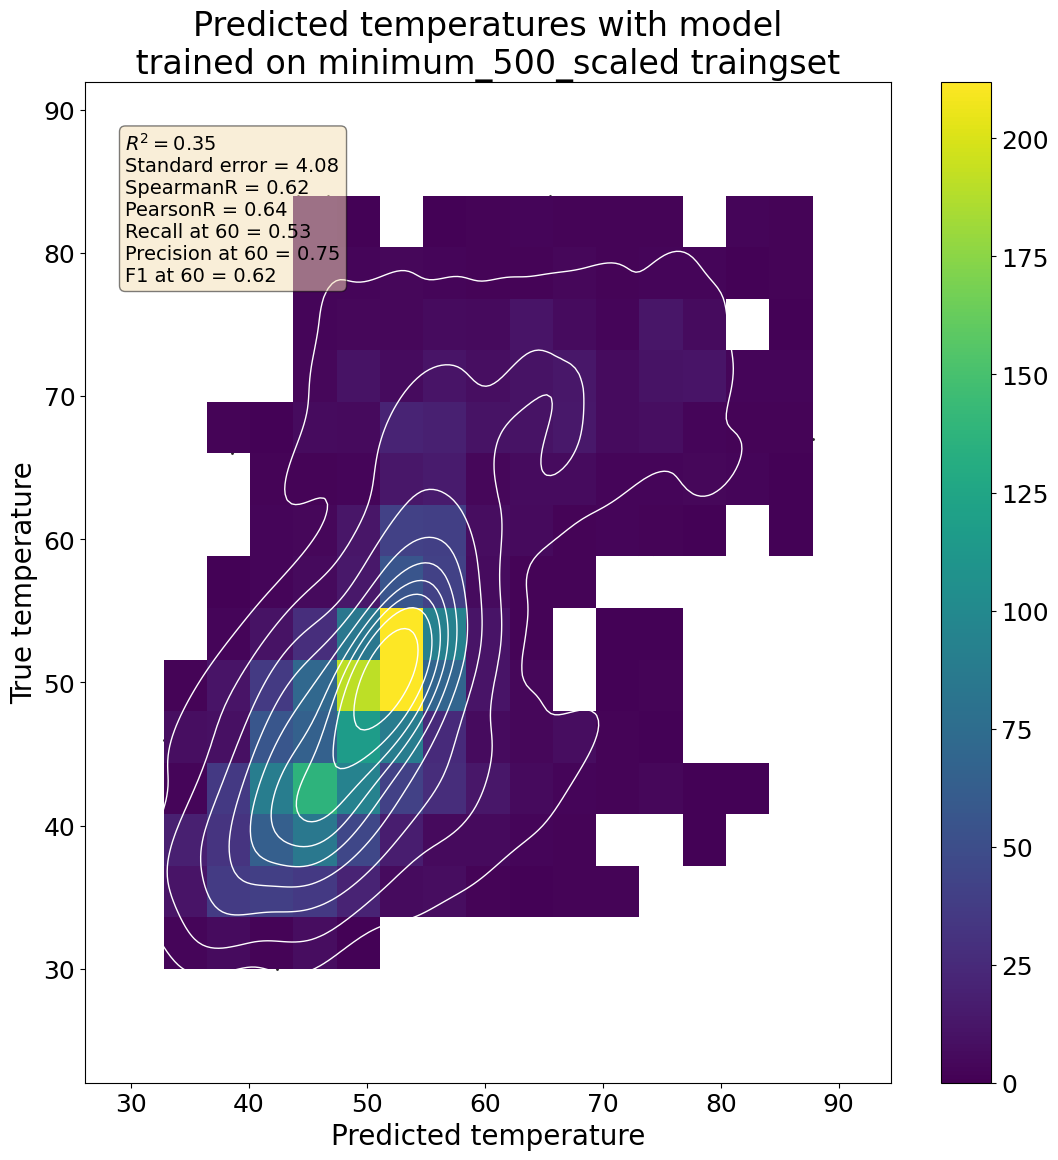

In [134]:
top_temp = 60
x = model_up_200.predict(x_test)

x = x.reshape((x.shape[0]))

f, ax = plt.subplots(figsize=[13, 13])
sns.scatterplot(x=x, y=y_test, s=5, color=".15")

sns.histplot(x=x, y=y_test, bins=15,cmap="viridis", cbar = True, pmax = 0.9)
sns.kdeplot(x=x, y=y_test, levels=10, color="w", linewidths=1)
#plt.xlim([2,103])
#plt.ylim([2, 103])
plt.title("Predicted temperatures with model\n trained on minimum_500_scaled traingset ")
plt.xlabel("Predicted temperature")
plt.ylabel("True temperature")

r = sklearn.metrics.r2_score(y_test, x)
e = sklearn.metrics.explained_variance_score(y_test, x)
mse = sklearn.metrics.mean_squared_error(y_test, x)
mdi = sklearn.metrics.median_absolute_error(y_test, x)

precision_60_up_200 = sklearn.metrics.precision_score(y_test > top_temp, x > top_temp)
f1_60_up_200 = sklearn.metrics.f1_score(y_test > top_temp, x > top_temp)
recal_60_up_200 = sklearn.metrics.recall_score(y_test > top_temp, x > top_temp)
mdi_60_up_200 = sklearn.metrics.median_absolute_error(y_test[y_test > top_temp], x[y_test > top_temp])

corr_p, _ = pearsonr(y_test, x)
corr_s, _ = spearmanr(y_test, x)
print("R square {}  ".format(r))
print("MSE {}".format(mse))
print("Median absolute error {}".format(mdi))
print("Explained varience {}".format(e))
print("Pearson correlation {}".format(corr_p))
print("Spearman correlation {}".format(corr_s))
print(f"Reacal at {top_temp} = {recal_60_up_200}")
print(f"Precision at {top_temp} = {precision_60_up_200}")
print(f"F1 at {top_temp} = {f1_60_up_200}")

textstr = '\n'.join((
    r'$R^2 = %.2f$' % (r, ),
    r'Standard error = %.2f' % (mdi, ),
    r'SpearmanR = %.2f' % (corr_s, ),
    r'PearsonR = %.2f' % (corr_p, ),
    r'Recall at %d = %.2f' % (top_temp, recal_60_up_200,),
    r'Precision at %d = %.2f' % (top_temp, precision_60_up_200,),
    r'F1 at %d = %.2f' % (top_temp, f1_60_up_200)))


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig("../results/img/img_reg_upscale_500.png")



In [129]:
df_scores = {"Scaling": ["No scaling", "Uniform", "Minimum_500"], "Recal": [recal_60, recal_60_up, recal_60_up_200], "Precision": [precision_60, precision_60_up, precision_60_up_200], "F1": [f1_60, f1_60_up, f1_60_up_200], "Standard Error at 60": [mdi_60, mdi_60_up, mdi_60_up_200] }
df_scores = pd.DataFrame(df_scores)
df_score_long = pd.melt(df_scores, id_vars=["Scaling"], value_vars=["Recal", "Precision", "F1"])

In [112]:
print(precision_60)
print(recal_60)
print(precision_60_up)
print(recal_60_up)
print(precision_60_up_200)
print(recal_60_up_200)

0.8413461538461539
0.4060324825986079
0.6945244956772334
0.5591647331786543
0.7261146496815286
0.5290023201856149


In [124]:
df_score_long

,Scaling,variable,value
0,No scaling,Recal,0.406032
1,Uniform,Recal,0.559165
2,Minimum 500,Recal,0.529002
3,No scaling,Precision,0.841346
4,Uniform,Precision,0.694524
5,Minimum 500,Precision,0.726115
6,No scaling,F1,0.547731
7,Uniform,F1,0.619537
8,Minimum 500,F1,0.612081
9,No scaling,Standard Error at 60,10.807293


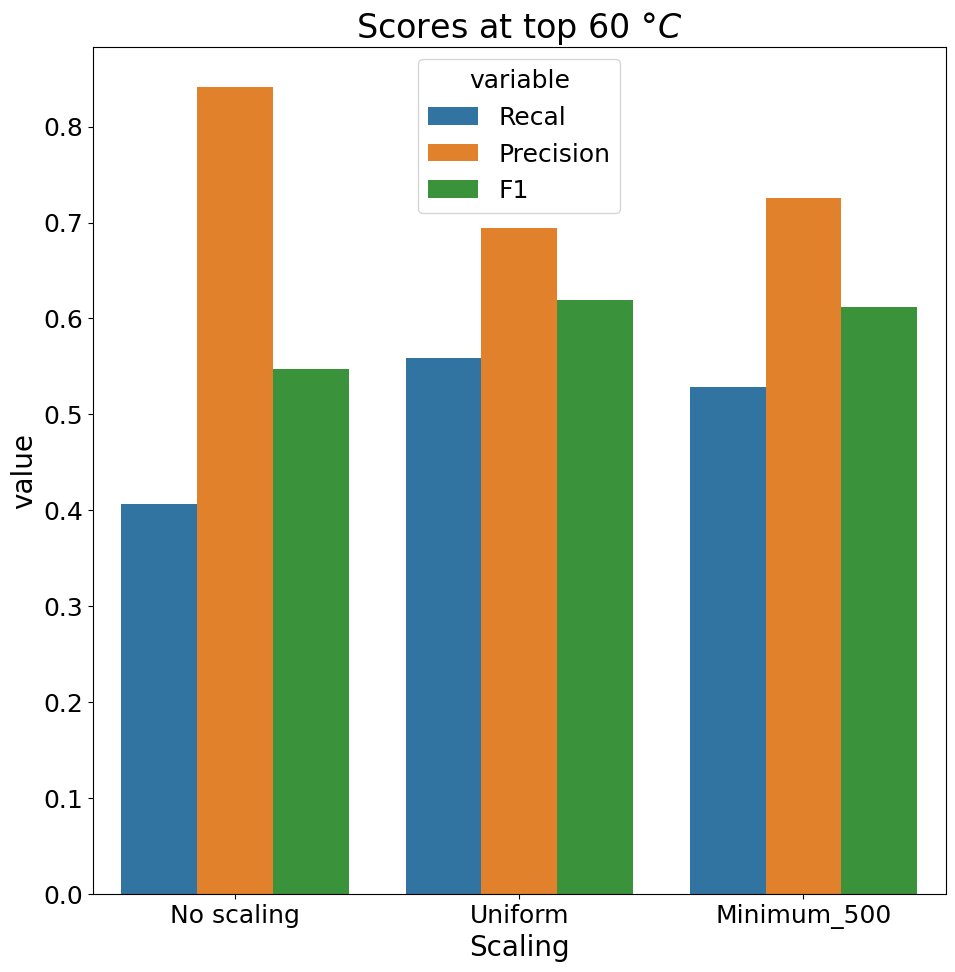

In [135]:
f, ax = plt.subplots(figsize=[11, 11])
sns.barplot(df_score_long, x="Scaling", y="value", hue="variable")
plt.title(r"Scores at top 60 $\degree C$")
plt.savefig("../results/img/img_scores_at_60.png")